In [ ]:
# import pandas as pd

# train = pd.read_csv('./data/train.csv')
# test = pd.read_csv('./data/test.csv')

In [ ]:
# train.info()

In [ ]:
# null_rows = train[train.isnull().any(axis=1)]

# print(null_rows)

In [ ]:
# train.dropna(inplace=True)
# train.info()

In [ ]:
# test.info()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# train['Num_words_ST'] = train['selected_text'].apply(lambda x:len(str(x).split()))
# train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split()))

# plt.figure(figsize=(12, 6))
# sns.kdeplot(train['Num_words_ST'], shade=True, color="#6c8ebf", label='Selected Text')
# sns.kdeplot(train['Num_word_text'], shade=True, color="#82B366", label='Text')
# plt.title('Distribution of words number',fontsize=14, fontweight='bold', position=(0.20, 1.0+0.05))
# plt.xlabel('Words Number',fontsize=14)
# plt.ylabel('Density',fontsize=14)
# plt.legend()
# plt.show()

In [ ]:
# train.drop(columns=['text'], inplace=True)
# train.rename(columns={'selected_text': 'text'}, inplace=True)

# train.info()

In [ ]:
# from sklearn.model_selection import train_test_split

# train_temp, test = train_test_split(train, test_size=0.2, random_state=42)
# train, validation = train_test_split(train_temp, test_size=0.25, random_state=42)

# train.to_csv("./dataset/train.csv", index=False)
# validation.to_csv("./dataset/validation.csv", index=False)
# test.to_csv("./dataset/test.csv", index=False)

In [1]:
import pandas as pd

train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
validation = pd.read_csv("./dataset/validation.csv")

# Funnel-Chart

In [ ]:
from plotly import graph_objs as go

temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
colors = ['#B3B3B3','#6c8ebf', '#82B366']

fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Sentiment Distribution"},
    marker=dict(colors=colors)  
))
fig.show()

In [2]:
import re
import nltk
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
more_stopwords = {'u', "im", "day"}
stop_words  = stop_words.union(more_stopwords)    
    
# Basic text cleaning 
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_text(text):
    text = str(text).lower()                                         # Convert to lowercase
    text = re.sub('\[.*?\]', '', text)                               # Remove text in square bracket   
    text = re.sub('https?://\S+|www\.\S+', '', text)                 # Remove links
    text = strip_html(text)                                          # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\n', '', text)                                    # Remove line breaks
    text = re.sub('\w*\d\w*', '', text)                              # Remove characters contain digits
    return text

def preprocess_text(text):
    text = clean_text(text)
    # Tokenization
    tokens = nltk.word_tokenize(text) 
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Apply preprocessing
train['tokens'] = train['text'].apply(preprocess_text)
test['tokens'] = test['text'].apply(preprocess_text)
validation['tokens'] = validation['text'].apply(preprocess_text)

C:\Users\ROG\AppData\Local\Temp\ipykernel_13800\762806120.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\ROG\AppData\Local\Temp\ipykernel_13800\762806120.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
C:\Users\ROG\AppData\Local\Temp\ipykernel_13800\762806120.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [4]:
from gensim.models import Word2Vec

# Concatenate tokens for Word2Vec training
all_tokens = pd.concat([train['tokens'], test['tokens'], validation['tokens']], axis=0)

# sg: 1-skip-gram; 0(default)-CBOW
# hs: 1-hierarchica softmax; 0(default)-negative sampling
model_w2v = Word2Vec(sentences=all_tokens, vector_size=100, window=10, sg=1, hs=1, min_count=1, workers=4)

In [5]:
import numpy as np

# Function to convert tokens to vectors, using zero vector for unknown words
def tokens_to_vectors(tokens, model):
    vectors = [model.wv[word] if word in model.wv else np.zeros((model.vector_size,)) for word in tokens]
    return np.array(vectors)

train['vectors'] = train['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))
test['vectors'] = test['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))
validation['vectors'] = validation['tokens'].apply(lambda tokens: tokens_to_vectors(tokens, model_w2v))

In [6]:
# Find the maximum sequence length to use for padding
max_seq_length = max(train['vectors'].apply(len).max(),test['vectors'].apply(len).max(),validation['vectors'].apply(len).max())
max_seq_length

23

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences
X_train_padded = pad_sequences(train['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')
X_test_padded = pad_sequences(test['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')
X_val_padded = pad_sequences(validation['vectors'].tolist(), maxlen=max_seq_length, dtype='float32', padding='post')

In [8]:
from sklearn.preprocessing import LabelEncoder

# Convert sentiment labels to numerical values
le= LabelEncoder()
train['label']= le.fit_transform(train['sentiment'])
test['label'] = le.transform(test['sentiment'])
validation['label'] = le.transform(validation['sentiment'])

y_train = train['label'].values
y_test= test['label'].values
y_val = validation['label'].values

In [ ]:
train.drop(columns=['textID'])

In [ ]:
test.drop(columns=['textID'])

In [ ]:
validation.drop(columns=['textID'])

In [ ]:
for sentiment in np.unique(y_train):
    sentiment_label = le.inverse_transform([sentiment])[0]
    sentiment_indices = np.where(y_train == sentiment)[0]
    print(f"Train - {sentiment_label}: {len(sentiment_indices)}")
print("")

for sentiment in np.unique(y_val):
    sentiment_label = le.inverse_transform([sentiment])[0]
    sentiment_indices = np.where(y_val == sentiment)[0]
    print(f"Validation - {sentiment_label}: {len(sentiment_indices)}")
print("")

for sentiment in np.unique(y_test):
    sentiment_label = le.inverse_transform([sentiment])[0]
    sentiment_indices = np.where(y_test == sentiment)[0]
    print(f"Test - {sentiment_label}: {len(sentiment_indices)}")

# Most common words Sentiments Wise

In [ ]:
train['list'] = train['text'].apply(preprocess_text)
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [ ]:
from collections import Counter

# Most common positive words
top = Counter([item for sublist in Positive_sent['list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive = temp_positive.iloc[1:,:]
temp_positive.columns = ['Common positive words','count']
temp_positive.style.background_gradient(cmap='Blues')

In [ ]:
# Most common negative words

top = Counter([item for sublist in Negative_sent['list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common negative words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [ ]:
# Most common neutral words

top = Counter([item for sublist in Neutral_sent['list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common neutral words','count']
temp_neutral.style.background_gradient(cmap='Greens')

# Unique Words in each Segment

In [ ]:
raw_text = [word for word_list in train['list'] for word in word_list]

def words_unique(sentiment,numwords,raw_words):
    allother = []
    for item in train[train.sentiment != sentiment]['list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in train[train.sentiment == sentiment]['list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [ ]:
Unique_Positive= words_unique('positive', 10, raw_text)
print("Top 10 unique positive words:")
Unique_Positive.style.background_gradient(cmap='Blues')

In [ ]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("Top 10 unique negative words:")
Unique_Negative.style.background_gradient(cmap='Reds')

In [ ]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("Top 10 unique neutral words:")
Unique_Neutral.style.background_gradient(cmap='Greens')

In [ ]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Conv1D, Activation, GlobalMaxPooling1D, Concatenate, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.initializers import he_normal

# class MultiHeadAttention(layers.Layer):
#     def __init__(self, embed_dim, num_heads, **kwargs):
#         super(MultiHeadAttention, self).__init__(**kwargs)
#         self.num_heads = num_heads
#         self.embed_dim = embed_dim
#         if embed_dim % num_heads != 0:
#             raise ValueError("embedding dimension must be divisible by number of heads ")
#         self.head_dim = embed_dim // num_heads
        
#         self.query = Dense(embed_dim)
#         self.key = Dense(embed_dim)
#         self.value = Dense(embed_dim)
#         self.combine_heads = Dense(embed_dim)

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'num_heads': self.num_heads,
#             'embed_dim': self.embed_dim
#         })
#         return config
    
#     def attention(self, query, key, value):
#         score = tf.matmul(query, key, transpose_b=True)
#         dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
#         scaled_score = score / tf.math.sqrt(dim_key)
#         weights = tf.nn.softmax(scaled_score, axis=-1)
#         output = tf.matmul(weights, value)
#         return output, weights

#     def separate_heads(self, x, batch_size):
#         x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
#         return tf.transpose(x, perm=[0, 2, 1, 3])

#     def call(self, inputs):
#         batch_size = tf.shape(inputs)[0]
        
#         # Linearly project the queries, keys, and values
#         query = self.query(inputs) 
#         key = self.key(inputs)
#         value = self.value(inputs) 
        
#         # Split into multiple heads (batch_size, num_heads, max_seq_length, head_dim)
#         query = self.separate_heads(query, batch_size) 
#         key = self.separate_heads(key, batch_size) 
#         value = self.separate_heads(value, batch_size) 

#         # Calculate attention scores
#         attention, weights = self.attention(query, key, value)
#         attention = tf.transpose(attention, perm=[0, 2, 1, 3])
#         concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        
#         # Linearly combine the heads
#         output = self.combine_heads(concat_attention)
#         return output, weights

# 1. Find Best L1/L2 Param

In [ ]:
# from tensorflow.keras.models import Sequential
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.regularizers import l1
# import matplotlib.pyplot as plt

# plt.rcParams['figure.dpi'] = 150
# values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
# all_train, all_test = list(), list()

# embedding_dim = model_w2v.vector_size
# input_layer = Input(shape=(max_seq_length, embedding_dim))

# for param in values:
#     attention_out, _ = MultiHeadAttention(embed_dim=embedding_dim, num_heads=4)(input_layer)

#     # TextCNN
#     filter_sizes = [3, 4, 5]
#     pool_outputs = []

#     for filter_size in filter_sizes:
#         conv = Conv1D(filters=128, kernel_size=filter_size, padding='same',
#                       kernel_initializer='he_normal',kernel_regularizer=l1(param),
#                       data_format='channels_last', use_bias=True)(attention_out)
#         act = Activation('relu')(conv)
#         norm = BatchNormalization()(act)
#         max_pool = GlobalMaxPooling1D(data_format='channels_last')(conv)
#         pool_outputs.append(max_pool)

#     concatenated = Concatenate()(pool_outputs)
#     dense = Dense(256, activation='relu')(concatenated)
#     dropout = Dropout(0.5)(dense)
#     output = Dense(3, activation='softmax')(dropout)

#     model = Model(inputs=input_layer, outputs=output)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     model.fit(X_train_padded, y_train, epochs=30, verbose=0)

#     _, train_acc = model.evaluate(X_train_padded, y_train, verbose=0)
#     _, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    
#     print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
#     all_train.append(train_acc)
#     all_test.append(test_acc)

# 2. Find Best Dropout Rate

In [ ]:
# from tensorflow.keras.models import Sequential
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.regularizers import l2
# import matplotlib.pyplot as plt

# plt.rcParams['figure.dpi'] = 150
# values = [0.2, 0.3, 0.4, 0.5]
# all_train, all_test = list(), list()

# embedding_dim = model_w2v.vector_size
# input_layer = Input(shape=(max_seq_length, embedding_dim))

# for param in values:
#     attention_out, _ = MultiHeadAttention(embed_dim=embedding_dim, num_heads=4)(input_layer)

#     # TextCNN
#     filter_sizes = [3, 4, 5]
#     pool_outputs = []

#     for filter_size in filter_sizes:
#         conv = Conv1D(filters=128, kernel_size=filter_size, padding='same',
#                       kernel_initializer='he_normal',kernel_regularizer=l2(1e-4),
#                       data_format='channels_last', use_bias=True)(attention_out)
#         act = Activation('relu')(conv)
#         norm = BatchNormalization()(act)
#         max_pool = GlobalMaxPooling1D(data_format='channels_last')(conv)
#         pool_outputs.append(max_pool)

#     concatenated = Concatenate()(pool_outputs)
#     dense = Dense(256, activation='relu')(concatenated)
#     dropout = Dropout(param)(dense)
#     output = Dense(3, activation='softmax')(dropout)

#     model = Model(inputs=input_layer, outputs=output)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     model.fit(X_train_padded, y_train, epochs=30, verbose=0)

#     _, train_acc = model.evaluate(X_train_padded, y_train, verbose=0)
#     _, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    
#     print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
#     all_train.append(train_acc)
#     all_test.append(test_acc)

# 3. Find Best Filters

In [ ]:
# from tensorflow.keras.models import Sequential
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.regularizers import l2
# import matplotlib.pyplot as plt

# plt.rcParams['figure.dpi'] = 150
# values = [32, 64, 128, 256]
# all_train, all_test = list(), list()

# embedding_dim = model_w2v.vector_size
# input_layer = Input(shape=(max_seq_length, embedding_dim))

# for param in values:
#     attention_out, _ = MultiHeadAttention(embed_dim=embedding_dim, num_heads=4)(input_layer)

#     # TextCNN
#     filter_sizes = [3, 4, 5]
#     pool_outputs = []

#     for filter_size in filter_sizes:
#         conv = Conv1D(filters=param, kernel_size=filter_size, padding='same',
#                       kernel_initializer='he_normal',kernel_regularizer=l2(1e-4),
#                       data_format='channels_last', use_bias=True)(attention_out)
#         act = Activation('relu')(conv)
#         norm = BatchNormalization()(act)
#         max_pool = GlobalMaxPooling1D(data_format='channels_last')(conv)
#         pool_outputs.append(max_pool)

#     concatenated = Concatenate()(pool_outputs)
#     dense = Dense(256, activation='relu')(concatenated)
#     dropout = Dropout(0.4)(dense)
#     output = Dense(3, activation='softmax')(dropout)

#     model = Model(inputs=input_layer, outputs=output)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     model.fit(X_train_padded, y_train, epochs=30, verbose=0)

#     _, train_acc = model.evaluate(X_train_padded, y_train, verbose=0)
#     _, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    
#     print('Param: %f, Train: %.3f, Test: %.3f' % (param, train_acc, test_acc))
#     all_train.append(train_acc)
#     all_test.append(test_acc)

In [ ]:
# plt.semilogx(values, all_train, label='train', marker='o',color='#6c8ebf')
# plt.semilogx(values, all_test, label='test', marker='s',color='#82B366')
# plt.xlabel('L1 param')
# plt.ylabel('ACCURACY')
# plt.legend(loc='best')
# plt.grid(True)
# plt.show()

# Proposed Model

In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Activation, GlobalMaxPooling1D, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal

embedding_dim = model_w2v.vector_size
input_layer = Input(shape=(max_seq_length, embedding_dim))

class MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        if embed_dim % num_heads != 0:
            raise ValueError("embedding dimension must be divisible by number of heads ")
        self.head_dim = embed_dim // num_heads
        
        self.query = Dense(embed_dim)
        self.key = Dense(embed_dim)
        self.value = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_heads': self.num_heads,
            'embed_dim': self.embed_dim
        })
        return config
    
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        # Linearly project the queries, keys, and values
        query = self.query(inputs) 
        key = self.key(inputs)
        value = self.value(inputs) 
        
        # Split into multiple heads (batch_size, num_heads, max_seq_length, head_dim)
        query = self.separate_heads(query, batch_size) 
        key = self.separate_heads(key, batch_size) 
        value = self.separate_heads(value, batch_size) 

        # Calculate attention scores
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        
        # Linearly combine the heads
        output = self.combine_heads(concat_attention)
        return output, weights

attention_out, attention_weights = MultiHeadAttention(embed_dim=embedding_dim, num_heads=4)(input_layer)

# TextCNN
l1_reg = l1(l1=1e-3)
filter_sizes = [3, 4, 5]
pool_outputs = []

for filter_size in filter_sizes:
    conv = Conv1D(filters=128, kernel_size=filter_size, padding='same',
                  kernel_initializer='he_normal',kernel_regularizer=l1_reg,
                  data_format='channels_last',use_bias=True)(attention_out)
    act = Activation('relu')(conv)
    norm = BatchNormalization()(act)
    max_pool = GlobalMaxPooling1D(data_format='channels_last')(conv)
    pool_outputs.append(max_pool)
    
concatenated = Concatenate()(pool_outputs)
dense = Dense(256, activation='relu')(concatenated)
dropout = Dropout(0.4)(dense)
output = Dense(3, activation='softmax')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 23, 100)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ [(None, None, 100),       │          40,400 │ input_layer[0][0]          │
│ (MultiHeadAttention)          │ (None, 4, None, None)]    │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, None, 128)         │          38,528 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, None, 128)         │          51,328 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, None, 128)         │          64,128 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d          │ (None, 128)               │               0 │ conv1d[0][0]               │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_1        │ (None, 128)               │               0 │ conv1d_1[0][0]             │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling1d_2        │ (None, 128)               │               0 │ conv1d_2[0][0]             │
│ (GlobalMaxPooling1D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 384)               │               0 │ global_max_pooling1d[0][0… │
│                               │                           │                 │ global_max_pooling1d_1[0]… │
│                               │                           │                 │ global_max_pooling1d_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 256)               │          98,560 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 3)                 │             771 │ dropout[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 293,715 (1.12 MB)

 Trainable params: 293,715 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.schedules import ExponentialDecay

# initial_lr = 0.001
# lr_schedule = ExponentialDecay(
#     initial_lr,
#     decay_steps=35, 
#     decay_rate=0.9
# )


weight = {0: 1.18, 1: 0.83, 2: 1.06}

model.compile(optimizer = Adam(learning_rate=3e-4),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train_padded, 
    y_train, 
    validation_data=(X_val_padded, y_val), 
    epochs=50, 
    class_weight = weight,
    batch_size=32
)

Epoch 1/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.6280 - loss: 5.9981 - val_accuracy: 0.7151 - val_loss: 1.0947
Epoch 2/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7288 - loss: 0.9460 - val_accuracy: 0.7434 - val_loss: 0.7532
Epoch 3/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.7421 - loss: 0.7523 - val_accuracy: 0.7505 - val_loss: 0.7116
Epoch 4/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7491 - loss: 0.7095 - val_accuracy: 0.7511 - val_loss: 0.6870
Epoch 5/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7514 - loss: 0.6936 - val_accuracy: 0.7455 - val_loss: 0.6866
Epoch 6/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7536 - loss: 0.6825 - val_accuracy: 0.7400 - val_loss: 0.6915
Epoch 7/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7598 - loss: 0.6658 - val_accuracy: 0.7538 - val_loss: 0.6732
Epoch 8/50
516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7601 - loss: 0.6636 - 

516/516 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7975 - loss: 0.5552 - val_accuracy: 0.7782 - val_loss: 0.6035


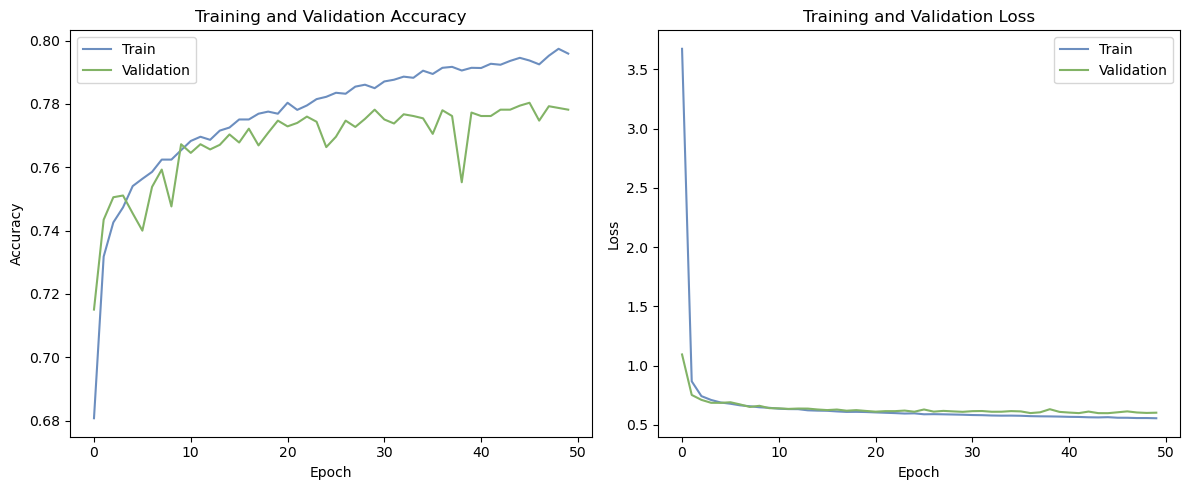

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#6c8ebf')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#82B366')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='best')

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#6c8ebf')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#82B366')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='best')
plt.tight_layout()
plt.show()

In [ ]:
model.save('cnn.keras')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('cnn.keras', custom_objects={'MultiHeadAttention': MultiHeadAttention})

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Visualize the attention weights

In [ ]:
import seaborn as sns

attention_model = Model(inputs=model.input, outputs=[model.output, attention_weights])

def visualize_attention_weights(sentence, attention_model):
    tokens = preprocess_text(sentence)
    print(f"Tokens after preprocessing: {tokens}")
    
    vectors = tokens_to_vectors(tokens, model_w2v)
    vectors_padded = pad_sequences([vectors], maxlen=max_seq_length, dtype='float32', padding='post')
    
    prediction, attention_weights = attention_model.predict(vectors_padded)
    attention_weights = attention_weights.flatten()
    attention_weights = attention_weights[:len(tokens)]  
    
    plt.figure(figsize=(len(tokens), 1))
    sns.heatmap([attention_weights], annot=True, cmap='Blues', cbar=False, xticklabels=tokens)
    plt.xticks(rotation=45)
    plt.show()

# Randomly select two texts
random_indices = np.random.choice(test.index, size=2, replace=False)
sentences = test['text'].loc[random_indices]

for sentence in sentences:
    visualize_attention_weights(sentence, attention_model)

# PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

y_train = train['label'].values
# model_attention_output = Model(inputs=model.input, outputs=attention_out)
attention_output = attention_model.predict(X_train_padded)

# Perform PCA on the features to reduce to 2D for visualization
pca = PCA(n_components=2)
# reduced_attention_output = pca.fit_transform(attention_output.reshape(attention_output.shape[0], -1))
reduced_attention_output = pca.fit_transform(attention_output)

# Plotting the features after the attention layer
plt.figure(figsize=(10, 8))
plt.scatter(reduced_attention_output[:, 0], reduced_attention_output[:, 1], c=y_train, cmap='viridis')
plt.title("Features Visualization after Attention Mechanism")
plt.colorbar()
plt.show()

model_dense_output = Model(inputs=model.input, outputs=dense)
dense_output = model_dense_output.predict(X_train_padded)

# Perform PCA on these features as well
reduced_dense_output = pca.fit_transform(dense_output)

# Plotting the features before the softmax layer
plt.figure(figsize=(10, 8))
plt.scatter(reduced_dense_output[:, 0], reduced_dense_output[:, 1], c=y_train, cmap='viridis')
plt.title("Features Visualization before Softmax Layer")
plt.colorbar()
plt.show()

# t-SNE

In [ ]:
from sklearn.manifold import TSNE

model_attention_output = Model(inputs=model.input, outputs=attention_out)
attention_output = model_attention_output.predict(X_train_padded)

tsne = TSNE(n_components=2, random_state=42)

# Perform t-SNE on the attention mechanism output
tsne_attention_output = tsne.fit_transform(attention_output.reshape(attention_output.shape[0], -1))

# Plotting the features after the attention layer
plt.figure(figsize=(10, 8))
plt.scatter(tsne_attention_output[:, 0], tsne_attention_output[:, 1], c=y_train, cmap='viridis')
plt.title("Features Visualization after Attention Mechanism")
plt.colorbar()
plt.show()

model_dense_output = Model(inputs=model.input, outputs=dense)
dense_output = model_dense_output.predict(X_train_padded)

# Perform t-SNE on the output before the softmax layer
tsne_dense_output = tsne.fit_transform(dense_output)

# Plotting the features before the softmax layer
plt.figure(figsize=(10, 8))
plt.scatter(tsne_dense_output[:, 0], tsne_dense_output[:, 1], c=y_train, cmap='viridis')
plt.title("Features Visualization before Softmax Layer")
plt.colorbar()
plt.show()

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes for test set
y_pred = np.argmax(model.predict(X_test_padded), axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with sentiment labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Report

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

In [ ]:
y_test

In [ ]:
import pandas as pd

# Convert predicted labels to a DataFrame
df_results = pd.DataFrame({'Text':test['text'],
                           'True_Label': le.inverse_transform(y_test),
                           'Predicted_Label': le.inverse_transform(y_pred)})

df_results

# ROC-AUC curve

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Convert y_test to one-hot encoded format if it's not already
if len(y_test.shape) == 1:
    label_binarizer = LabelBinarizer()
    y_test = label_binarizer.fit_transform(y_test)

# Calculate the ROC AUC Score
y_prob = model.predict(X_test_padded)
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"ROC-AUC Score: {roc_auc_ovr:0.2f}")

# Compute ROC curve and ROC area for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = cycle(['#6c8ebf', '#B3B3B3', '#82B366'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()

# PR

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_prob[:, i])

plt.figure(figsize=(8, 6))

colors = cycle(['#6c8ebf', '#B3B3B3', '#82B366'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='{0} (AP = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

# WordCloud

In [ ]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
posText = train[train['sentiment'] == 'positive']['text']
negText = train[train['sentiment'] == 'negative']['text']
neuText = train[train['sentiment'] == 'neutral']['text']

# Tokenize and extract words for each sentiment category
posWord = [word.lower() for text in posText for word in word_tokenize(str(text))]
negWord = [word.lower() for text in negText for word in word_tokenize(str(text))]
neuWord = [word.lower() for text in neuText for word in word_tokenize(str(text))]

stop_words = set(stopwords.words('english'))
positive = [word for word in posWord if word not in stop_words]
negative = [word for word in negWord if word not in stop_words]
neutral = [word for word in neuWord if word not in stop_words]

def plot_word_cloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white',colormap= 'coolwarm').generate(' '.join(words))
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_word_cloud(positive, 'Positive Word Cloud')

In [ ]:
plot_word_cloud(negative, 'Negative Word Cloud')

In [ ]:
plot_word_cloud(neutral, 'Neutral Word Cloud')

In [ ]:
positive_words = set(positive)
negative_words = set(negative)
neutral_words = set(neutral)

def classify_text(text):
    processed_text = preprocess_text(text)
    text_vector = tokens_to_vectors(processed_text, model_w2v)
    text_vector_padded = pad_sequences([text_vector], maxlen=max_seq_length, dtype='float32', padding='post')

    prediction = model.predict(text_vector_padded)
    sentiment = le.inverse_transform([np.argmax(prediction)])

    # 检查文本中的关键词与情感词库的匹配
    positive_count = sum(word in positive_words for word in processed_text)
    negative_count = sum(word in negative_words for word in processed_text)
    neutral_count = sum(word in neutral_words for word in processed_text)

    # 综合模型预测和词库统计来确定最终情感
    if max(positive_count, negative_count, neutral_count) > 0:
        if positive_count > max(negative_count, neutral_count):
            return "positive"
        elif negative_count > max(positive_count, neutral_count):
            return "negative"
        elif neutral_count > max(positive_count, negative_count):
            return "neutral"
    return sentiment[0]

user_input = input("Enter text: ")
print("Predicted label:", classify_text(user_input))

In [ ]:
sentiment_lexicon = {
    "positive": posWord,
    "negative": negWord,
    "neutral": neuWord    
}

def get_average_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Calculate average vectors for sentiment categories
average_vectors = {sentiment: get_average_vector(words, model_w2v) for sentiment, words in sentiment_lexicon.items()}

In [ ]:
user_input = input("Enter text: ")
user_tokens = preprocess_text(user_input)

# Convert tokens to vectors using Word2Vec model
# user_vectors = tokens_to_vectors(user_tokens, model_w2v)
user_vectors = get_average_vector(user_tokens, model_w2v).reshape(1, -1)

# Pad sequences
padded_user_input = pad_sequences([user_vectors], maxlen=max_seq_length, dtype='float32', padding='post')

# Perform prediction using the model
prediction = model.predict(padded_user_input)

predicted_label = np.argmax(prediction[0], axis=-1)
pred_label = le.inverse_transform([predicted_label])

print("Predicted label:", pred_label)